In [1]:
import torch
torch.cuda.empty_cache()
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
import os


ablation_study_id = 4
os.chdir('../')

In [2]:
gdsc_df = pd.read_csv("dataset/GDSC_SMILES_merged.csv", index_col=0)
gdsc_df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES
0,1003,Camptothecin,PFSK-1,-1.462148,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
1,1003,Camptothecin,A673,-4.869447,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
2,1003,Camptothecin,ES5,-3.360684,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
3,1003,Camptothecin,ES7,-5.045014,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
4,1003,Camptothecin,EW-11,-3.741620,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
...,...,...,...,...,...
242031,2499,N-acetyl cysteine,SNU-175,10.134495,CC(=O)NC(CS)C(=O)O
242032,2499,N-acetyl cysteine,SNU-407,8.575555,CC(=O)NC(CS)C(=O)O
242033,2499,N-acetyl cysteine,SNU-61,10.520666,CC(=O)NC(CS)C(=O)O
242034,2499,N-acetyl cysteine,SNU-C5,10.701430,CC(=O)NC(CS)C(=O)O


In [3]:
ccl_rep_df = pd.read_csv("dataset/PANCANCER_Genetic_feature.csv")

# Pivot to get binary matrix: rows = cell lines, columns = features
binary_feature_matrix = ccl_rep_df.pivot_table(
    index="cell_line_name",
    columns="genetic_feature",
    values="is_mutated",
    fill_value=0
).astype(int)

In [4]:
binary_feature_matrix.columns = binary_feature_matrix.columns.astype(str)

In [5]:
binary_feature_matrix

genetic_feature,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,cnaPANCAN90,cnaPANCAN91,cnaPANCAN92,cnaPANCAN93,cnaPANCAN94,cnaPANCAN95,cnaPANCAN96,cnaPANCAN97,cnaPANCAN98,cnaPANCAN99
cell_line_name,,,,,,,,,,,,,,,,,,,,,
201T,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22RV1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23132-87,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42-MG-BA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
451Lu,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZR-75-30,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
huH-1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


In [6]:
binary_feature_matrix.index = binary_feature_matrix.index.str.upper()

In [7]:
import re

def clean_name(name):
    return re.sub(r'[^A-Za-z0-9]', '', name).upper()

### CCL embeddings

In [8]:
binary_feature_matrix.index = binary_feature_matrix.index.to_series().apply(clean_name)
binary_feature_matrix

genetic_feature,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,cnaPANCAN90,cnaPANCAN91,cnaPANCAN92,cnaPANCAN93,cnaPANCAN94,cnaPANCAN95,cnaPANCAN96,cnaPANCAN97,cnaPANCAN98,cnaPANCAN99
cell_line_name,,,,,,,,,,,,,,,,,,,,,
201T,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22RV1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2313287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42MGBA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
451LU,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZR7530,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
HUH1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


### Drugs

In [9]:
gdsc_df["CLEAN_CELL_LINE"] = gdsc_df["CELL_LINE_NAME"].apply(clean_name)
gdsc_df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES,CLEAN_CELL_LINE
0,1003,Camptothecin,PFSK-1,-1.462148,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,PFSK1
1,1003,Camptothecin,A673,-4.869447,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,A673
2,1003,Camptothecin,ES5,-3.360684,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,ES5
3,1003,Camptothecin,ES7,-5.045014,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,ES7
4,1003,Camptothecin,EW-11,-3.741620,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,EW11
...,...,...,...,...,...,...
242031,2499,N-acetyl cysteine,SNU-175,10.134495,CC(=O)NC(CS)C(=O)O,SNU175
242032,2499,N-acetyl cysteine,SNU-407,8.575555,CC(=O)NC(CS)C(=O)O,SNU407
242033,2499,N-acetyl cysteine,SNU-61,10.520666,CC(=O)NC(CS)C(=O)O,SNU61
242034,2499,N-acetyl cysteine,SNU-C5,10.701430,CC(=O)NC(CS)C(=O)O,SNUC5


### Fingerprints

In [10]:
def compute_morgan(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [0] * n_bits
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return list(fp)


In [11]:
unique_drugs = gdsc_df[["DRUG_ID", "SMILES"]].drop_duplicates().reset_index(drop=True)
unique_drugs["FINGERPRINT"] = unique_drugs["SMILES"].apply(compute_morgan)
fingerprint_dict = dict(zip(unique_drugs["DRUG_ID"], unique_drugs["FINGERPRINT"]))

[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerator
[20:51:24] DEPRECATION WARNING: please use MorganGenerat

### GSVA scores

In [12]:
gsva_df = pd.read_csv("dataset/ccle_gsva_scores.csv", index_col=0)
gsva_df

,X22RV1_PROSTATE,X2313287_STOMACH,X253JBV_URINARY_TRACT,X253J_URINARY_TRACT,X42MGBA_CENTRAL_NERVOUS_SYSTEM,X5637_URINARY_TRACT,X59M_OVARY,X639V_URINARY_TRACT,X647V_URINARY_TRACT,X697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
KEGG_MEDICUS_ENV_FACTOR_ARSENIC_TO_ELECTRON_TRANSFER_IN_COMPLEX_IV,0.244789,-0.083931,0.279529,0.208577,-0.132328,0.215197,0.319143,-0.075647,0.277187,0.271370,...,0.075112,0.327630,-0.375213,-0.355703,-0.101719,-0.530021,-0.537348,0.275503,0.526732,0.220102
KEGG_MEDICUS_ENV_FACTOR_BENZO_A_PYRENRE_TO_CYP_MEDIATED_METABOLISM,0.232631,0.414819,0.290806,0.670978,-0.274907,0.192912,0.640286,-0.506128,-0.057853,-0.455609,...,-0.274736,0.131784,0.551961,0.211546,-0.032558,0.151900,0.317689,-0.332108,-0.430653,0.182114
KEGG_MEDICUS_ENV_FACTOR_DCE_TO_DNA_ADDUCTS,-0.186705,0.177009,-0.414291,-0.038181,0.207581,0.134153,0.586046,-0.158105,-0.045624,-0.519046,...,-0.145654,0.178017,0.254041,-0.116195,-0.179142,0.231483,0.155220,0.205721,-0.166378,0.045039
KEGG_MEDICUS_ENV_FACTOR_E2_TO_NUCLEAR_INITIATED_ESTROGEN_SIGNALING_PATHWAY,-0.540508,-0.258760,-0.138647,0.146632,-0.384697,-0.019662,0.407990,-0.288576,-0.125966,0.616469,...,0.087120,-0.160979,0.192224,0.457628,0.006197,-0.417248,-0.453304,-0.136213,0.387118,0.503203
KEGG_MEDICUS_ENV_FACTOR_E2_TO_RAS_ERK_SIGNALING_PATHWAY,-0.166025,0.121127,-0.259766,-0.369504,0.117981,0.406653,-0.132804,0.414331,0.543123,-0.071814,...,0.112035,0.091719,-0.332850,0.156438,-0.064297,0.338911,0.224560,0.143953,0.002501,0.102778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_VGCC_CA2_APOPTOTIC_PATHWAY,-0.117058,0.534826,0.499067,0.476963,0.491432,-0.041223,-0.021224,-0.637564,-0.262915,-0.128982,...,-0.316305,-0.194693,0.727817,0.157373,0.250761,-0.209867,0.035322,0.055748,0.194295,0.100961
KEGG_MEDICUS_VARIANT_TEL_AML1_FUSION_TO_TRANSCRIPTIONAL_REPRESSION,-0.071946,-0.235064,-0.158232,-0.471312,0.069451,0.552709,-0.219726,-0.231657,0.247514,0.479034,...,0.471183,0.543891,0.173360,0.325866,0.628831,0.454693,0.169221,0.040660,-0.249230,-0.453372
KEGG_MEDICUS_VARIANT_TGFA_OVEREXPRESSION_TO_PI3K_SIGNALING_PATHWAY,-0.288375,-0.230789,-0.043607,-0.100954,-0.003728,0.443881,-0.040789,-0.123535,0.551131,0.003992,...,-0.070541,0.065449,0.058856,0.208207,0.303945,0.378906,0.233616,0.152003,-0.139507,-0.157565
KEGG_MEDICUS_VARIANT_TMPRSS2_ERG_FUSION_TO_TRANSCRIPTIONAL_ACTIVATION,-0.566128,-0.454890,0.398130,0.312828,0.524678,0.477288,0.634019,-0.273644,0.437712,0.101343,...,0.100011,-0.227126,0.728999,0.366406,0.542634,-0.223423,0.224992,0.234498,-0.452274,-0.463809


In [13]:
gdsc_df["CELL_LINE_NAME"] = gdsc_df["CELL_LINE_NAME"].str.strip().str.upper()
cell_lines_obs = set(gdsc_df["CELL_LINE_NAME"].unique())

gsva_df.columns = gsva_df.columns.str.strip().str.upper()
cell_lines_available = sorted(set(gsva_df.columns.str.split("_").str[0].str.upper()))

In [14]:
cell_lines_available = {clean_name(name) for name in cell_lines_available}
cell_lines_obs = {clean_name(name) for name in cell_lines_obs}

In [15]:
common_cell_lines = cell_lines_obs.intersection(cell_lines_available)
print("Now common cell lines:", len(common_cell_lines))

Now common cell lines: 607


In [16]:
gsva_df.columns = gsva_df.columns.str.split("_").str[0].str.upper().to_series().apply(clean_name)
gsva_df.columns.has_duplicates

True

In [17]:
gsva_df = gsva_df.loc[:, ~gsva_df.columns.duplicated()]
print(gsva_df.columns.has_duplicates)
gsva_df

False


,X22RV1,X2313287,X253JBV,X253J,X42MGBA,X5637,X59M,X639V,X647V,X697,...,WSUDLCL2,YAPC,YD10B,YD15,YD38,YD8,YH13,YKG1,ZR751,ZR7530
KEGG_MEDICUS_ENV_FACTOR_ARSENIC_TO_ELECTRON_TRANSFER_IN_COMPLEX_IV,0.244789,-0.083931,0.279529,0.208577,-0.132328,0.215197,0.319143,-0.075647,0.277187,0.271370,...,0.075112,0.327630,-0.375213,-0.355703,-0.101719,-0.530021,-0.537348,0.275503,0.526732,0.220102
KEGG_MEDICUS_ENV_FACTOR_BENZO_A_PYRENRE_TO_CYP_MEDIATED_METABOLISM,0.232631,0.414819,0.290806,0.670978,-0.274907,0.192912,0.640286,-0.506128,-0.057853,-0.455609,...,-0.274736,0.131784,0.551961,0.211546,-0.032558,0.151900,0.317689,-0.332108,-0.430653,0.182114
KEGG_MEDICUS_ENV_FACTOR_DCE_TO_DNA_ADDUCTS,-0.186705,0.177009,-0.414291,-0.038181,0.207581,0.134153,0.586046,-0.158105,-0.045624,-0.519046,...,-0.145654,0.178017,0.254041,-0.116195,-0.179142,0.231483,0.155220,0.205721,-0.166378,0.045039
KEGG_MEDICUS_ENV_FACTOR_E2_TO_NUCLEAR_INITIATED_ESTROGEN_SIGNALING_PATHWAY,-0.540508,-0.258760,-0.138647,0.146632,-0.384697,-0.019662,0.407990,-0.288576,-0.125966,0.616469,...,0.087120,-0.160979,0.192224,0.457628,0.006197,-0.417248,-0.453304,-0.136213,0.387118,0.503203
KEGG_MEDICUS_ENV_FACTOR_E2_TO_RAS_ERK_SIGNALING_PATHWAY,-0.166025,0.121127,-0.259766,-0.369504,0.117981,0.406653,-0.132804,0.414331,0.543123,-0.071814,...,0.112035,0.091719,-0.332850,0.156438,-0.064297,0.338911,0.224560,0.143953,0.002501,0.102778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_VGCC_CA2_APOPTOTIC_PATHWAY,-0.117058,0.534826,0.499067,0.476963,0.491432,-0.041223,-0.021224,-0.637564,-0.262915,-0.128982,...,-0.316305,-0.194693,0.727817,0.157373,0.250761,-0.209867,0.035322,0.055748,0.194295,0.100961
KEGG_MEDICUS_VARIANT_TEL_AML1_FUSION_TO_TRANSCRIPTIONAL_REPRESSION,-0.071946,-0.235064,-0.158232,-0.471312,0.069451,0.552709,-0.219726,-0.231657,0.247514,0.479034,...,0.471183,0.543891,0.173360,0.325866,0.628831,0.454693,0.169221,0.040660,-0.249230,-0.453372
KEGG_MEDICUS_VARIANT_TGFA_OVEREXPRESSION_TO_PI3K_SIGNALING_PATHWAY,-0.288375,-0.230789,-0.043607,-0.100954,-0.003728,0.443881,-0.040789,-0.123535,0.551131,0.003992,...,-0.070541,0.065449,0.058856,0.208207,0.303945,0.378906,0.233616,0.152003,-0.139507,-0.157565
KEGG_MEDICUS_VARIANT_TMPRSS2_ERG_FUSION_TO_TRANSCRIPTIONAL_ACTIVATION,-0.566128,-0.454890,0.398130,0.312828,0.524678,0.477288,0.634019,-0.273644,0.437712,0.101343,...,0.100011,-0.227126,0.728999,0.366406,0.542634,-0.223423,0.224992,0.234498,-0.452274,-0.463809


# Creating Dataset

In [18]:
from rdkit import Chem
import torch
from torch_geometric.data import Data

from torch.utils.data import Dataset


In [19]:
# Define categorical vocabularies
ATOM_LIST = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'H', 'B', 'Si', 'Na', 'K', 'Li', 'Mg', 'Ca', 'Fe', 'Zn', 'Se', 'Cu']
DEGREE_LIST = list(range(0, 11))
VALENCE_LIST = list(range(0, 7))
HYBRIDIZATION_LIST = [
    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
TOTAL_H_LIST = [0, 1, 2, 3, 4]
CHIRALITY_LIST = ['R', 'S']

In [20]:
def one_hot_encoding(x, allowable):
    return [int(x == s) for s in allowable]

In [21]:
def atom_features(atom):
    features = []
    features += one_hot_encoding(atom.GetSymbol(), ATOM_LIST)
    features += one_hot_encoding(atom.GetDegree(), DEGREE_LIST)
    features += one_hot_encoding(atom.GetImplicitValence(), VALENCE_LIST)
    features.append(atom.GetFormalCharge())
    features.append(atom.GetNumRadicalElectrons())
    features += one_hot_encoding(atom.GetHybridization(), HYBRIDIZATION_LIST)
    features.append(int(atom.GetIsAromatic()))
    features += one_hot_encoding(atom.GetTotalNumHs(), TOTAL_H_LIST)
    features.append(int(atom.IsInRing()))
    
    chirality = atom.GetProp('_CIPCode') if atom.HasProp('_CIPCode') else None
    features += one_hot_encoding(chirality, CHIRALITY_LIST)
    
    return features


In [22]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    atom_feats = [atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_feats, dtype=torch.float)

    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # undirected

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    return Data(x=x, edge_index=edge_index)

In [23]:
import re
from torch.utils.data import Dataset
import torch

class ModifiedMGATAFDataset(Dataset):
    def __init__(self, gdsc_df, fingerprint_dict, cell_feature_matrix, gsva_matrix, graph_dict):
        self.df = gdsc_df
        self.fingerprint_dict = fingerprint_dict  # drug_id -> np.array or list
        self.cell_features = cell_feature_matrix  # DataFrame: index=cell_line_name, values=mutation+cnv
        self.gsva_matrix = gsva_matrix            # DataFrame: index=cell_line_name, values=gsva scores
        self.graphs = graph_dict                  # drug_id -> graph object (PyG or DGL)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug_id = row["DRUG_ID"]
        cell_line = row["CLEAN_CELL_LINE"]

        # Drug molecular graph
        graph_data = self.graphs[drug_id]

        # Fingerprint vector
        fingerprint = torch.tensor(self.fingerprint_dict[drug_id], dtype=torch.float)

        # Cell line mutation/CNV features
        ccl_feat = torch.tensor(self.cell_features.loc[cell_line].values, dtype=torch.float)

        # GSVA pathway scores
        if cell_line not in gsva_matrix.index:
            raise ValueError(f"{cell_line} not found in GSVA matrix.")
        gsva_feat = torch.tensor(self.gsva_matrix.loc[cell_line].values, dtype=torch.float)

        # Target IC50
        ic50 = torch.tensor([row["LN_IC50"]], dtype=torch.float)

        return graph_data, fingerprint, ccl_feat, gsva_feat, ic50


In [24]:
# Step 1: Clean the GDSC cell line column
# gdsc_df["CELL_LINE_NAME_CLEAN"] = gdsc_df["CELL_LINE_NAME"].apply(clean_name)

# Step 2: Clean the index of the binary feature matrix
binary_feature_matrix.index = binary_feature_matrix.index.to_series().apply(clean_name)
binary_feature_matrix = binary_feature_matrix[~binary_feature_matrix.index.duplicated(keep='first')]

# Step 3: Clean GSVA matrix columns
gsva_df.columns = gsva_df.columns.to_series().apply(clean_name)
gsva_df = gsva_df.loc[:, ~gsva_df.columns.duplicated(keep='first')]

# Step 4: Determine valid IDs
valid_drugs = set(fingerprint_dict.keys())
valid_mutcnv_cells = set(binary_feature_matrix.index)
valid_gsva_cells = set(gsva_df.columns)

# Step 5: Get cell lines common to all three
common_cell_lines = valid_mutcnv_cells & valid_gsva_cells & set(gdsc_df["CLEAN_CELL_LINE"])
common_cell_lines = list(common_cell_lines)
# Step 6: Filter gdsc_df to keep only rows with common cell lines and valid drugs/SMILES
gdsc_df = gdsc_df[
    gdsc_df["DRUG_ID"].isin(valid_drugs) &
    gdsc_df["CLEAN_CELL_LINE"].isin(common_cell_lines) &
    gdsc_df["SMILES"].notna()
].reset_index(drop=True)

# Step 7: Filter binary_feature_matrix and gsva_matrix to keep only common cell lines
binary_feature_matrix = binary_feature_matrix.loc[common_cell_lines]
gsva_df = gsva_df.loc[:, list(common_cell_lines)]  # since cell lines are columns

# Normalise the ln IC50 values
gdsc_df['LN_IC50'] = 1 / (np.exp(-0.1 * gdsc_df['LN_IC50']) + 1)

In [25]:
gdsc_df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES,CLEAN_CELL_LINE
0,1003,Camptothecin,A673,0.380614,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,A673
1,1003,Camptothecin,SK-ES-1,0.374186,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,SKES1
2,1003,Camptothecin,COLO-829,0.469282,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,COLO829
3,1003,Camptothecin,RT4,0.426465,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,RT4
4,1003,Camptothecin,SW780,0.463887,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,SW780
...,...,...,...,...,...,...
125091,2499,N-acetyl cysteine,MM1S,0.717484,CC(=O)NC(CS)C(=O)O,MM1S
125092,2499,N-acetyl cysteine,SNU-175,0.733695,CC(=O)NC(CS)C(=O)O,SNU175
125093,2499,N-acetyl cysteine,SNU-407,0.702150,CC(=O)NC(CS)C(=O)O,SNU407
125094,2499,N-acetyl cysteine,SNU-61,0.741172,CC(=O)NC(CS)C(=O)O,SNU61


In [26]:
binary_feature_matrix

genetic_feature,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,cnaPANCAN90,cnaPANCAN91,cnaPANCAN92,cnaPANCAN93,cnaPANCAN94,cnaPANCAN95,cnaPANCAN96,cnaPANCAN97,cnaPANCAN98,cnaPANCAN99
cell_line_name,,,,,,,,,,,,,,,,,,,,,
NCIH446,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
DMS114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SH4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BHY,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
LP1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCIH3122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OCIAML2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [27]:
drug_smiles = gdsc_df.drop_duplicates(subset="DRUG_ID")[["DRUG_ID", "SMILES"]]

In [28]:
precomputed_graphs = {}
for _, row in drug_smiles.iterrows():
    drug_id = row["DRUG_ID"]
    smi = row["SMILES"]
    graph = smiles_to_graph(smi)
    if graph is not None:
        precomputed_graphs[drug_id] = graph

In [29]:
gsva_df

,NCIH446,DMS114,SH4,BHY,LP1,DMS79,NCIH2066,HUH7,MDST8,ABC1,...,TE6,HT115,COLO792,KLE,HCC1500,A673,NCIH3122,OCIAML2,SIGM5,SNU61
KEGG_MEDICUS_ENV_FACTOR_ARSENIC_TO_ELECTRON_TRANSFER_IN_COMPLEX_IV,0.025563,0.052185,0.344959,-0.593710,-0.022756,-0.467708,-0.619180,0.320350,0.341117,0.027451,...,-0.123492,0.782699,0.437165,0.700152,0.379520,0.018496,0.091954,0.054120,0.604587,0.386269
KEGG_MEDICUS_ENV_FACTOR_BENZO_A_PYRENRE_TO_CYP_MEDIATED_METABOLISM,-0.344059,-0.419224,-0.474718,0.624072,-0.480376,-0.243344,0.201735,0.586432,-0.263689,-0.052492,...,0.738549,0.731209,-0.187668,0.323003,0.128488,-0.009474,0.679646,-0.577172,-0.344415,0.491696
KEGG_MEDICUS_ENV_FACTOR_DCE_TO_DNA_ADDUCTS,-0.138687,0.100212,0.086226,-0.452828,-0.529496,-0.204084,0.201725,0.523547,0.268196,-0.384908,...,0.657841,0.546099,0.329454,0.510121,-0.390043,0.253067,-0.062948,-0.006430,0.026751,0.542320
KEGG_MEDICUS_ENV_FACTOR_E2_TO_NUCLEAR_INITIATED_ESTROGEN_SIGNALING_PATHWAY,-0.216055,-0.320956,-0.142173,-0.086050,-0.250994,0.333464,0.570975,-0.108167,0.377726,-0.100228,...,0.395868,-0.032258,0.177890,0.599245,0.106780,0.034885,0.520426,-0.498412,-0.264710,0.383251
KEGG_MEDICUS_ENV_FACTOR_E2_TO_RAS_ERK_SIGNALING_PATHWAY,-0.035599,-0.180195,0.403123,-0.259793,0.322123,-0.069570,0.076265,0.221339,0.342109,0.216335,...,-0.079939,-0.086394,0.371157,0.081627,0.104569,0.044851,-0.379883,-0.320845,-0.319786,-0.011766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_VGCC_CA2_APOPTOTIC_PATHWAY,0.375151,-0.291022,0.483249,0.153546,-0.100278,-0.121320,-0.157521,-0.482178,0.291392,0.404718,...,0.231635,0.475347,0.017158,-0.031865,-0.244306,-0.202008,0.073855,-0.065742,-0.017882,0.251035
KEGG_MEDICUS_VARIANT_TEL_AML1_FUSION_TO_TRANSCRIPTIONAL_REPRESSION,0.032104,-0.261773,-0.117398,-0.407246,-0.563206,0.023914,-0.147121,-0.103935,0.130897,-0.316974,...,0.227682,-0.091330,-0.461364,-0.376247,-0.339093,-0.043965,0.429224,0.552003,0.619808,0.288543
KEGG_MEDICUS_VARIANT_TGFA_OVEREXPRESSION_TO_PI3K_SIGNALING_PATHWAY,0.026329,-0.124177,0.079414,0.345905,-0.403791,0.434209,-0.513955,-0.480947,0.121643,0.145638,...,0.524648,-0.487138,-0.058771,0.463774,-0.285446,-0.523954,-0.552732,0.204465,-0.150288,-0.245645
KEGG_MEDICUS_VARIANT_TMPRSS2_ERG_FUSION_TO_TRANSCRIPTIONAL_ACTIVATION,-0.190286,-0.599528,-0.016642,0.442426,-0.407392,-0.558982,-0.480779,-0.193559,0.438671,-0.624304,...,-0.369800,-0.089553,0.100691,0.583987,-0.608487,-0.240124,0.284692,-0.089532,0.398752,0.083956


In [30]:
gsva_matrix = gsva_df.T  # Now cell lines are rows
gsva_matrix

,KEGG_MEDICUS_ENV_FACTOR_ARSENIC_TO_ELECTRON_TRANSFER_IN_COMPLEX_IV,KEGG_MEDICUS_ENV_FACTOR_BENZO_A_PYRENRE_TO_CYP_MEDIATED_METABOLISM,KEGG_MEDICUS_ENV_FACTOR_DCE_TO_DNA_ADDUCTS,KEGG_MEDICUS_ENV_FACTOR_E2_TO_NUCLEAR_INITIATED_ESTROGEN_SIGNALING_PATHWAY,KEGG_MEDICUS_ENV_FACTOR_E2_TO_RAS_ERK_SIGNALING_PATHWAY,KEGG_MEDICUS_ENV_FACTOR_IRON_TO_ANTEROGRADE_AXONAL_TRANSPORT,KEGG_MEDICUS_ENV_FACTOR_METALS_TO_JNK_SIGNALING_PATHWAY,KEGG_MEDICUS_ENV_FACTOR_METALS_TO_KEAP1_NRF2_SIGNALIG_PATHWAY,KEGG_MEDICUS_ENV_FACTOR_METALS_TO_NFKB_SIGNALING_PATHWAY,KEGG_MEDICUS_ENV_FACTOR_METALS_TO_RAS_ERK_SIGNALING_PATHWAY,...,KEGG_MEDICUS_VARIANT_RET_FUSION_KINASE_TO_RAS_ERK_SIGNALING_PATHWAY,KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_26S_PROTEASOME_MEDIATED_PROTEIN_DEGRADATION,KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_MGLUR5_CA2_APOPTOTIC_PATHWAY,KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_PERK_ATF4_SIGNALING_PATHWAY,KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_TRANSPORT_OF_CALCIUM,KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_VGCC_CA2_APOPTOTIC_PATHWAY,KEGG_MEDICUS_VARIANT_TEL_AML1_FUSION_TO_TRANSCRIPTIONAL_REPRESSION,KEGG_MEDICUS_VARIANT_TGFA_OVEREXPRESSION_TO_PI3K_SIGNALING_PATHWAY,KEGG_MEDICUS_VARIANT_TMPRSS2_ERG_FUSION_TO_TRANSCRIPTIONAL_ACTIVATION,KEGG_MEDICUS_VARIANT_TRK_FUSION_KINASE_TO_RAS_ERK_SIGNALING_PATHWAY
NCIH446,0.025563,-0.344059,-0.138687,-0.216055,-0.035599,0.489445,-0.242937,-0.365318,0.244078,0.038230,...,-0.085216,-0.422535,-0.195127,-0.262608,-0.110226,0.375151,0.032104,0.026329,-0.190286,0.092889
DMS114,0.052185,-0.419224,0.100212,-0.320956,-0.180195,0.126427,-0.455066,-0.642900,-0.243706,-0.077914,...,0.412924,0.289092,-0.131222,-0.494402,-0.030551,-0.291022,-0.261773,-0.124177,-0.599528,0.400275
SH4,0.344959,-0.474718,0.086226,-0.142173,0.403123,0.306735,0.056540,0.089264,0.312676,0.472044,...,0.315552,0.064542,0.302367,0.589016,0.062371,0.483249,-0.117398,0.079414,-0.016642,0.345010
BHY,-0.593710,0.624072,-0.452828,-0.086050,-0.259793,-0.620749,-0.343202,-0.048123,-0.035106,-0.453270,...,-0.360848,-0.690174,-0.181061,0.468818,-0.230401,0.153546,-0.407246,0.345905,0.442426,-0.386175
LP1,-0.022756,-0.480376,-0.529496,-0.250994,0.322123,-0.670991,0.317314,-0.484232,-0.063634,0.396526,...,0.349128,0.036458,-0.125195,0.818096,-0.117314,-0.100278,-0.563206,-0.403791,-0.407392,0.403802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A673,0.018496,-0.009474,0.253067,0.034885,0.044851,0.483250,0.003465,0.024835,-0.071276,0.158425,...,0.349045,0.313582,-0.216811,-0.434115,-0.043350,-0.202008,-0.043965,-0.523954,-0.240124,0.335068
NCIH3122,0.091954,0.679646,-0.062948,0.520426,-0.379883,0.045211,-0.372871,0.406732,0.167042,-0.645806,...,-0.615370,0.469459,-0.008868,-0.152954,0.093438,0.073855,0.429224,-0.552732,0.284692,-0.607138
OCIAML2,0.054120,-0.577172,-0.006430,-0.498412,-0.320845,-0.530205,-0.270100,-0.649225,-0.237296,-0.272567,...,0.007655,-0.683895,0.129062,-0.442026,0.260365,-0.065742,0.552003,0.204465,-0.089532,-0.200937
SIGM5,0.604587,-0.344415,0.026751,-0.264710,-0.319786,-0.126523,-0.371033,-0.534170,-0.389660,-0.189615,...,-0.186440,-0.047718,0.118727,0.067469,0.153495,-0.017882,0.619808,-0.150288,0.398752,-0.252987


In [31]:
dataset = ModifiedMGATAFDataset(
    gdsc_df=gdsc_df,
    fingerprint_dict=fingerprint_dict,
    cell_feature_matrix=binary_feature_matrix,
    gsva_matrix=gsva_matrix,
    graph_dict=precomputed_graphs
)

In [32]:
sample = dataset[0]
graph, fingerprint, cell_feat, gsva_feat, label = sample

print("Graph:")
print(graph)
print("Graph node features shape:", graph.x.shape)
print("Graph edge_index shape:", graph.edge_index.shape)
print()

print("Fingerprint shape:", fingerprint.shape)
print("Cell line features shape:", cell_feat.shape)
print("GSVA features shape:", gsva_feat.shape)
print("Label (ln_IC50):", label)


Graph:
Data(x=[26, 55], edge_index=[2, 60])
Graph node features shape: torch.Size([26, 55])
Graph edge_index shape: torch.Size([2, 60])

Fingerprint shape: torch.Size([2048])
Cell line features shape: torch.Size([735])
GSVA features shape: torch.Size([658])
Label (ln_IC50): tensor([0.3806])


In [33]:
from torch_geometric.data import Batch

def modified_mgataf_collate_fn(batch):
    graphs, fingerprints, ccl_feats, gsva_feats, labels = zip(*batch)

    # Batch graph objects using PyG
    graph_batch = Batch.from_data_list(graphs)

    # Stack other tensors
    fingerprint_batch = torch.stack(fingerprints)
    ccl_feat_batch = torch.stack(ccl_feats)
    gsva_feat_batch = torch.stack(gsva_feats)
    label_batch = torch.stack(labels)

    return graph_batch, fingerprint_batch, ccl_feat_batch, gsva_feat_batch, label_batch


# Model Build

## Encoding

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_add_pool

In [35]:
class DrugGraphEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, out_dim=128, num_layers=3, heads=4):
        super().__init__()
        self.gats = nn.ModuleList()
        self.num_layers = num_layers
        self.att_proj = nn.Linear(hidden_dim, 1)

        self.gats.append(GATConv(in_dim, hidden_dim, heads=heads, concat=False))
        for _ in range(1, num_layers):
            self.gats.append(GATConv(hidden_dim, hidden_dim, heads=heads, concat=False))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        layer_outputs = []

        for gat in self.gats:
            x = F.relu(gat(x, edge_index))
            pooled = global_add_pool(x, batch)
            layer_outputs.append(pooled)

        h = torch.stack(layer_outputs, dim=1)  # [B, L, D]
        attn_weights = F.softmax(self.att_proj(h).squeeze(-1), dim=1)  # [B, L]
        h_weighted = (h * attn_weights.unsqueeze(-1)).sum(dim=1)  # [B, D]
        return h_weighted

In [36]:
class FingerprintEncoder(nn.Module):
    def __init__(self, in_dim=2048, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
        )

        # Dummy pass to infer output size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_dim)
            conv_out = self.conv(dummy)
            conv_flat_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_flat_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.fc(x)
        return x


In [37]:
class CellLineEncoder(nn.Module):
    def __init__(self, in_dim=735, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
        )

        # Dynamically infer flattened dimension
        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_dim)
            conv_out = self.conv(dummy)
            flat_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, 735]
        x = self.conv(x)
        x = self.fc(x)
        return x


In [38]:
class GSVAEncoder(nn.Module):
    def __init__(self, in_dim=658, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_dim)
            conv_out = self.conv(dummy)
            flat_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, 658]
        x = self.conv(x)
        x = self.fc(x)
        return x


## Adaptive Fusion

In [39]:
class AdaptiveFusion(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gate_layer = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        # x1: drug + fp, x2: ccl
        concat = torch.cat([x1, x2], dim=1)
        gate = self.gate_layer(concat)

        fused = gate * x1 + (1 - gate) * x2
        return fused


## Final Dense Layer

In [40]:
class IC50Predictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)


## Complete Model

In [41]:
class ModifiedMGATAFModel(nn.Module):
    def __init__(self, atom_feat_dim=55, fingerprint_dim=2048, ccl_dim=735, gsva_dim=658, hidden_dim=128):
        super().__init__()
        self.drug_encoder = DrugGraphEncoder(in_dim=atom_feat_dim, hidden_dim=hidden_dim)
        self.fp_encoder = FingerprintEncoder(in_dim=fingerprint_dim, out_dim=hidden_dim)

        # self.ccl_encoder = CellLineEncoder(in_dim=ccl_dim, out_dim=hidden_dim)
        self.gsva_encoder = GSVAEncoder(in_dim=gsva_dim, out_dim=hidden_dim)
        
        self.drug_fusion = AdaptiveFusion(input_dim=hidden_dim, hidden_dim=hidden_dim)
        # self.cellline_fusion = AdaptiveFusion(input_dim=hidden_dim, hidden_dim=hidden_dim)  # new!
        self.fusion = AdaptiveFusion(input_dim=hidden_dim, hidden_dim=hidden_dim)

        self.regressor = IC50Predictor(input_dim=hidden_dim)

    def forward(self, graph_data, fingerprint, ccl_feat, gsva_feat):
        # Drug branch
        drug_repr = self.drug_encoder(graph_data)
        fp_repr = self.fp_encoder(fingerprint)
        # drug_combined = drug_repr + fp_repr
        drug_combined = self.drug_fusion(drug_repr, fp_repr)

        # Cell line branch
        # ccl_repr = self.ccl_encoder(ccl_feat)
        gsva_repr = self.gsva_encoder(gsva_feat)
        # final_ccl_repr = self.cellline_fusion(ccl_repr, gsva_repr)

        # Final fusion
        fused = self.fusion(drug_combined, gsva_repr)

        return self.regressor(fused)

# Training

### Data Split

In [42]:
from sklearn.model_selection import train_test_split

indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.1, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)

from torch.utils.data import Subset
train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)
test_set = Subset(dataset, test_idx)

### Creating DataLoaders

In [43]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=modified_mgataf_collate_fn)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=modified_mgataf_collate_fn)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, collate_fn=modified_mgataf_collate_fn)

### Training Loop

In [44]:
torch.backends.cudnn.benchmark = True

In [45]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
Device name: NVIDIA RTX 6000 Ada Generation


In [46]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

import os

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedMGATAFModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_val_loss = float('inf')
patience_counter = 0
max_patience = 10
num_epochs = 100


# Trackers
train_rmse_list = []
val_rmse_list = []
val_pcc_list = []


# Paths
checkpoint_model_path = f"models/checkpoints/modified_mgataf_ablation/modified_mgataf_checkpoint_model_{ablation_study_id}.pt"
checkpoint_opt_path = f"models/checkpoints/modified_mgataf_ablation/mgataf_checkpoint_optim_{ablation_study_id}.pt"
checkpoint_meta_path = f"models/checkpoints/modified_mgataf_ablation/mgataf_checkpoint_meta_{ablation_study_id}.pt"

# Defaults
start_epoch = 0

# Resume
if os.path.exists(checkpoint_model_path) and os.path.exists(checkpoint_opt_path) and os.path.exists(checkpoint_meta_path):
    print("🔄 Resuming model...")
    model.load_state_dict(torch.load(checkpoint_model_path))

    # if os.path.exists(checkpoint_opt_path):
    optimizer.load_state_dict(torch.load(checkpoint_opt_path))

    # if os.path.exists(checkpoint_meta_path):
    meta = torch.load(checkpoint_meta_path)
    start_epoch = meta["epoch"] + 1
    best_val_loss = meta["best_val_loss"]
    patience_counter = meta["patience_counter"]

    print(f"✅ Resumed from epoch {start_epoch} | Best Val Loss: {best_val_loss:.4f}")


for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    train_preds, train_labels = [], []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
    for batch_idx, (graph_data, fingerprint, ccl_feat, gsva_feat, label) in enumerate(loop):
        graph_data = graph_data.to(device)
        fingerprint = fingerprint.to(device)
        ccl_feat = ccl_feat.to(device)
        gsva_feat = gsva_feat.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(graph_data, fingerprint, ccl_feat, gsva_feat)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        train_preds.append(output.detach().cpu().numpy())
        train_labels.append(label.cpu().numpy())
        
        # Every N batches, compute and show running metrics
        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
            pred_flat = np.concatenate(train_preds).flatten()
            label_flat = np.concatenate(train_labels).flatten()
            rmse = root_mean_squared_error(label_flat, pred_flat)
            try:
                pcc = pearsonr(label_flat, pred_flat)[0]
            except:
                pcc = float('nan')

            loop.set_postfix(train_rmse=f"{rmse:.4f}", train_pcc=f"{pcc:.4f}")

    train_preds_flat = np.concatenate(train_preds).flatten()
    train_labels_flat = np.concatenate(train_labels).flatten()
    train_rmse = root_mean_squared_error(train_labels_flat, train_preds_flat)
    train_rmse_list.append(train_rmse)

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for graph_data, fingerprint, ccl_feat, gsva_feat, label in val_loader:
            graph_data = graph_data.to(device)
            fingerprint = fingerprint.to(device)
            ccl_feat = ccl_feat.to(device)
            gsva_feat = gsva_feat.to(device)
            label = label.to(device)

            output = model(graph_data, fingerprint, ccl_feat, gsva_feat)
            val_preds.append(output.cpu().numpy())
            val_labels.append(label.cpu().numpy())

    val_preds_flat = np.concatenate(val_preds).flatten()
    val_labels_flat = np.concatenate(val_labels).flatten()
    val_rmse = root_mean_squared_error(val_labels_flat, val_preds_flat)
    val_pcc = pearsonr(val_preds_flat, val_labels_flat)[0]

    val_rmse_list.append(val_rmse)
    val_pcc_list.append(val_pcc)

    scheduler.step(val_rmse)

    print(f"[Epoch {epoch+1}] Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f} | Val PCC: {val_pcc:.4f}")

    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        patience_counter = 0
        torch.save(model.state_dict(), f"models/modified_mgataf_type{ablation_study_id}_best_model.pt")
        print(f"[Saved Best Model] | Val RMSE: {val_rmse:.4f} | Val PCC: {val_pcc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print("Early stopping triggered.")
            break

    if (epoch % 5) == 0:
        torch.save(model.state_dict(), checkpoint_model_path)
        torch.save(optimizer.state_dict(), checkpoint_opt_path)
        torch.save({
            "epoch": epoch,
            "best_val_loss": best_val_loss,
            "patience_counter": patience_counter
        }, checkpoint_meta_path)
        print(f"[Checkpointed Model and State] | Val RMSE: {val_rmse:.4f} | Val PCC: {val_pcc:.4f}")

Epoch 1: 100%|██████████| 1584/1584 [00:51<00:00, 30.83it/s, train_pcc=0.7947, train_rmse=0.0424]


[Epoch 1] Train RMSE: 0.0424 | Val RMSE: 0.0308 | Val PCC: 0.8962
[Saved Best Model] | Val RMSE: 0.0308 | Val PCC: 0.8962
[Checkpointed Model and State] | Val RMSE: 0.0308 | Val PCC: 0.8962


Epoch 2: 100%|██████████| 1584/1584 [00:50<00:00, 31.67it/s, train_pcc=0.8902, train_rmse=0.0313]


[Epoch 2] Train RMSE: 0.0313 | Val RMSE: 0.0319 | Val PCC: 0.9033


Epoch 3: 100%|██████████| 1584/1584 [00:52<00:00, 29.99it/s, train_pcc=0.9004, train_rmse=0.0299]


[Epoch 3] Train RMSE: 0.0299 | Val RMSE: 0.0286 | Val PCC: 0.9096
[Saved Best Model] | Val RMSE: 0.0286 | Val PCC: 0.9096


Epoch 4: 100%|██████████| 1584/1584 [00:50<00:00, 31.17it/s, train_pcc=0.9073, train_rmse=0.0289]


[Epoch 4] Train RMSE: 0.0289 | Val RMSE: 0.0283 | Val PCC: 0.9112
[Saved Best Model] | Val RMSE: 0.0283 | Val PCC: 0.9112


Epoch 5: 100%|██████████| 1584/1584 [00:50<00:00, 31.29it/s, train_pcc=0.9146, train_rmse=0.0278]


[Epoch 5] Train RMSE: 0.0278 | Val RMSE: 0.0271 | Val PCC: 0.9195
[Saved Best Model] | Val RMSE: 0.0271 | Val PCC: 0.9195


Epoch 6: 100%|██████████| 1584/1584 [00:50<00:00, 31.11it/s, train_pcc=0.9195, train_rmse=0.0270]


[Epoch 6] Train RMSE: 0.0270 | Val RMSE: 0.0269 | Val PCC: 0.9213
[Saved Best Model] | Val RMSE: 0.0269 | Val PCC: 0.9213
[Checkpointed Model and State] | Val RMSE: 0.0269 | Val PCC: 0.9213


Epoch 7: 100%|██████████| 1584/1584 [00:52<00:00, 30.19it/s, train_pcc=0.9236, train_rmse=0.0263]


[Epoch 7] Train RMSE: 0.0263 | Val RMSE: 0.0265 | Val PCC: 0.9234
[Saved Best Model] | Val RMSE: 0.0265 | Val PCC: 0.9234


Epoch 8: 100%|██████████| 1584/1584 [00:49<00:00, 32.23it/s, train_pcc=0.9268, train_rmse=0.0258]


[Epoch 8] Train RMSE: 0.0258 | Val RMSE: 0.0258 | Val PCC: 0.9270
[Saved Best Model] | Val RMSE: 0.0258 | Val PCC: 0.9270


Epoch 9: 100%|██████████| 1584/1584 [00:50<00:00, 31.62it/s, train_pcc=0.9298, train_rmse=0.0253]


[Epoch 9] Train RMSE: 0.0253 | Val RMSE: 0.0256 | Val PCC: 0.9279
[Saved Best Model] | Val RMSE: 0.0256 | Val PCC: 0.9279


Epoch 10: 100%|██████████| 1584/1584 [00:51<00:00, 30.71it/s, train_pcc=0.9329, train_rmse=0.0248]


[Epoch 10] Train RMSE: 0.0248 | Val RMSE: 0.0255 | Val PCC: 0.9283
[Saved Best Model] | Val RMSE: 0.0255 | Val PCC: 0.9283


Epoch 11: 100%|██████████| 1584/1584 [00:49<00:00, 32.27it/s, train_pcc=0.9350, train_rmse=0.0244]


[Epoch 11] Train RMSE: 0.0244 | Val RMSE: 0.0255 | Val PCC: 0.9284
[Checkpointed Model and State] | Val RMSE: 0.0255 | Val PCC: 0.9284


Epoch 12: 100%|██████████| 1584/1584 [00:49<00:00, 31.92it/s, train_pcc=0.9373, train_rmse=0.0240]


[Epoch 12] Train RMSE: 0.0240 | Val RMSE: 0.0252 | Val PCC: 0.9303
[Saved Best Model] | Val RMSE: 0.0252 | Val PCC: 0.9303


Epoch 13: 100%|██████████| 1584/1584 [00:52<00:00, 30.38it/s, train_pcc=0.9395, train_rmse=0.0235]


[Epoch 13] Train RMSE: 0.0235 | Val RMSE: 0.0249 | Val PCC: 0.9320
[Saved Best Model] | Val RMSE: 0.0249 | Val PCC: 0.9320


Epoch 14: 100%|██████████| 1584/1584 [00:50<00:00, 31.52it/s, train_pcc=0.9412, train_rmse=0.0232]


[Epoch 14] Train RMSE: 0.0232 | Val RMSE: 0.0265 | Val PCC: 0.9300


Epoch 15: 100%|██████████| 1584/1584 [00:50<00:00, 31.67it/s, train_pcc=0.9425, train_rmse=0.0230]


[Epoch 15] Train RMSE: 0.0230 | Val RMSE: 0.0259 | Val PCC: 0.9321


Epoch 16: 100%|██████████| 1584/1584 [00:51<00:00, 30.79it/s, train_pcc=0.9439, train_rmse=0.0227]


[Epoch 16] Train RMSE: 0.0227 | Val RMSE: 0.0252 | Val PCC: 0.9335
[Checkpointed Model and State] | Val RMSE: 0.0252 | Val PCC: 0.9335


Epoch 17: 100%|██████████| 1584/1584 [00:50<00:00, 31.36it/s, train_pcc=0.9453, train_rmse=0.0224]


[Epoch 17] Train RMSE: 0.0224 | Val RMSE: 0.0246 | Val PCC: 0.9341
[Saved Best Model] | Val RMSE: 0.0246 | Val PCC: 0.9341


Epoch 18: 100%|██████████| 1584/1584 [00:51<00:00, 30.81it/s, train_pcc=0.9463, train_rmse=0.0222]


[Epoch 18] Train RMSE: 0.0222 | Val RMSE: 0.0251 | Val PCC: 0.9321


Epoch 19: 100%|██████████| 1584/1584 [00:52<00:00, 30.09it/s, train_pcc=0.9478, train_rmse=0.0219]


[Epoch 19] Train RMSE: 0.0219 | Val RMSE: 0.0248 | Val PCC: 0.9325


Epoch 20: 100%|██████████| 1584/1584 [00:51<00:00, 30.69it/s, train_pcc=0.9488, train_rmse=0.0217]


[Epoch 20] Train RMSE: 0.0217 | Val RMSE: 0.0244 | Val PCC: 0.9347
[Saved Best Model] | Val RMSE: 0.0244 | Val PCC: 0.9347


Epoch 21: 100%|██████████| 1584/1584 [00:50<00:00, 31.48it/s, train_pcc=0.9498, train_rmse=0.0215]


[Epoch 21] Train RMSE: 0.0215 | Val RMSE: 0.0248 | Val PCC: 0.9337
[Checkpointed Model and State] | Val RMSE: 0.0248 | Val PCC: 0.9337


Epoch 22: 100%|██████████| 1584/1584 [00:49<00:00, 32.17it/s, train_pcc=0.9507, train_rmse=0.0213]


[Epoch 22] Train RMSE: 0.0213 | Val RMSE: 0.0244 | Val PCC: 0.9346


Epoch 23: 100%|██████████| 1584/1584 [00:51<00:00, 30.84it/s, train_pcc=0.9514, train_rmse=0.0212]


[Epoch 23] Train RMSE: 0.0212 | Val RMSE: 0.0252 | Val PCC: 0.9329


Epoch 24: 100%|██████████| 1584/1584 [00:50<00:00, 31.14it/s, train_pcc=0.9526, train_rmse=0.0209]


[Epoch 24] Train RMSE: 0.0209 | Val RMSE: 0.0249 | Val PCC: 0.9319


Epoch 25: 100%|██████████| 1584/1584 [00:49<00:00, 32.26it/s, train_pcc=0.9529, train_rmse=0.0209]


[Epoch 25] Train RMSE: 0.0209 | Val RMSE: 0.0244 | Val PCC: 0.9350
[Saved Best Model] | Val RMSE: 0.0244 | Val PCC: 0.9350


Epoch 26: 100%|██████████| 1584/1584 [00:49<00:00, 31.83it/s, train_pcc=0.9538, train_rmse=0.0207]


[Epoch 26] Train RMSE: 0.0207 | Val RMSE: 0.0248 | Val PCC: 0.9342
[Checkpointed Model and State] | Val RMSE: 0.0248 | Val PCC: 0.9342


Epoch 27: 100%|██████████| 1584/1584 [00:50<00:00, 31.53it/s, train_pcc=0.9548, train_rmse=0.0204]


[Epoch 27] Train RMSE: 0.0204 | Val RMSE: 0.0245 | Val PCC: 0.9341


Epoch 28: 100%|██████████| 1584/1584 [00:50<00:00, 31.52it/s, train_pcc=0.9551, train_rmse=0.0204]


[Epoch 28] Train RMSE: 0.0204 | Val RMSE: 0.0247 | Val PCC: 0.9344


Epoch 29: 100%|██████████| 1584/1584 [00:52<00:00, 30.39it/s, train_pcc=0.9557, train_rmse=0.0202]


[Epoch 29] Train RMSE: 0.0202 | Val RMSE: 0.0249 | Val PCC: 0.9337


Epoch 30: 100%|██████████| 1584/1584 [00:54<00:00, 29.28it/s, train_pcc=0.9564, train_rmse=0.0201]


[Epoch 30] Train RMSE: 0.0201 | Val RMSE: 0.0246 | Val PCC: 0.9345


Epoch 31: 100%|██████████| 1584/1584 [00:51<00:00, 30.62it/s, train_pcc=0.9569, train_rmse=0.0199]


[Epoch 31] Train RMSE: 0.0199 | Val RMSE: 0.0246 | Val PCC: 0.9339
[Checkpointed Model and State] | Val RMSE: 0.0246 | Val PCC: 0.9339


Epoch 32: 100%|██████████| 1584/1584 [00:51<00:00, 30.79it/s, train_pcc=0.9613, train_rmse=0.0189]


[Epoch 32] Train RMSE: 0.0189 | Val RMSE: 0.0241 | Val PCC: 0.9366
[Saved Best Model] | Val RMSE: 0.0241 | Val PCC: 0.9366


Epoch 33: 100%|██████████| 1584/1584 [00:51<00:00, 30.67it/s, train_pcc=0.9621, train_rmse=0.0187]


[Epoch 33] Train RMSE: 0.0187 | Val RMSE: 0.0244 | Val PCC: 0.9351


Epoch 34: 100%|██████████| 1584/1584 [00:51<00:00, 30.53it/s, train_pcc=0.9623, train_rmse=0.0187]


[Epoch 34] Train RMSE: 0.0187 | Val RMSE: 0.0244 | Val PCC: 0.9353


Epoch 35: 100%|██████████| 1584/1584 [00:51<00:00, 30.59it/s, train_pcc=0.9628, train_rmse=0.0186]


[Epoch 35] Train RMSE: 0.0186 | Val RMSE: 0.0245 | Val PCC: 0.9355


Epoch 36: 100%|██████████| 1584/1584 [00:52<00:00, 30.28it/s, train_pcc=0.9631, train_rmse=0.0185]


[Epoch 36] Train RMSE: 0.0185 | Val RMSE: 0.0245 | Val PCC: 0.9355
[Checkpointed Model and State] | Val RMSE: 0.0245 | Val PCC: 0.9355


Epoch 37: 100%|██████████| 1584/1584 [00:51<00:00, 30.60it/s, train_pcc=0.9635, train_rmse=0.0184]


[Epoch 37] Train RMSE: 0.0184 | Val RMSE: 0.0244 | Val PCC: 0.9350


Epoch 38: 100%|██████████| 1584/1584 [00:54<00:00, 28.89it/s, train_pcc=0.9637, train_rmse=0.0183]


[Epoch 38] Train RMSE: 0.0183 | Val RMSE: 0.0245 | Val PCC: 0.9344


Epoch 39: 100%|██████████| 1584/1584 [00:52<00:00, 30.39it/s, train_pcc=0.9660, train_rmse=0.0178]


[Epoch 39] Train RMSE: 0.0178 | Val RMSE: 0.0246 | Val PCC: 0.9344


Epoch 40: 100%|██████████| 1584/1584 [00:54<00:00, 29.00it/s, train_pcc=0.9663, train_rmse=0.0177]


[Epoch 40] Train RMSE: 0.0177 | Val RMSE: 0.0245 | Val PCC: 0.9346


Epoch 41: 100%|██████████| 1584/1584 [00:55<00:00, 28.76it/s, train_pcc=0.9666, train_rmse=0.0176]


[Epoch 41] Train RMSE: 0.0176 | Val RMSE: 0.0245 | Val PCC: 0.9345
[Checkpointed Model and State] | Val RMSE: 0.0245 | Val PCC: 0.9345


Epoch 42: 100%|██████████| 1584/1584 [00:55<00:00, 28.47it/s, train_pcc=0.9667, train_rmse=0.0176]


[Epoch 42] Train RMSE: 0.0176 | Val RMSE: 0.0245 | Val PCC: 0.9348
Early stopping triggered.


Split the dataset on DRUGS to ensure there are no dataleaks!!!

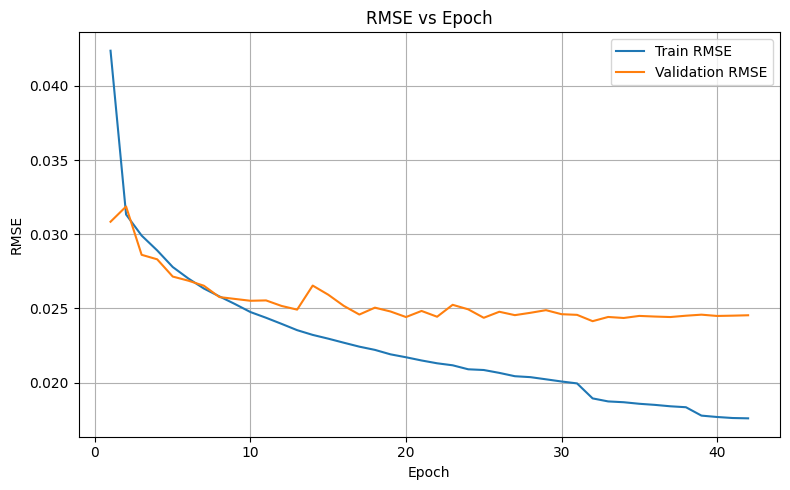

In [48]:
# Plot RMSE vs Epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, label="Train RMSE")
plt.plot(range(1, len(val_rmse_list)+1), val_rmse_list, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE vs Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing and Evaluation

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-initialize model
model = ModifiedMGATAFModel().to(device)

# Load best saved weights
model.load_state_dict(torch.load(f"models/modified_mgataf_type{ablation_study_id}_best_model.pt"))
model.eval()

ModifiedMGATAFModel(
  (drug_encoder): DrugGraphEncoder(
    (gats): ModuleList(
      (0): GATConv(55, 128, heads=4)
      (1-2): 2 x GATConv(128, 128, heads=4)
    )
    (att_proj): Linear(in_features=128, out_features=1, bias=True)
  )
  (fp_encoder): FingerprintEncoder(
    (conv): Sequential(
      (0): Conv1d(1, 32, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
      (3): ReLU()
    )
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=16256, out_features=128, bias=True)
      (2): ReLU()
    )
  )
  (gsva_encoder): GSVAEncoder(
    (conv): Sequential(
      (0): Conv1d(1, 32, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
      (3): ReLU()
    )
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=5120, out_features=128, bias=True)
      (2): ReLU()
    )
  )
  (drug_fusion): 

In [50]:
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for graph_data, fingerprint, ccl_feat, gsva_feat, label in test_loader:
        graph_data = graph_data.to(device)
        fingerprint = fingerprint.to(device)
        ccl_feat = ccl_feat.to(device)
        gsva_feat = gsva_feat.to(device)
        label = label.to(device)

        preds = model(graph_data, fingerprint, ccl_feat, gsva_feat)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(label.cpu().numpy())

# Flatten predictions and labels
y_pred = np.concatenate(all_preds).flatten()
y_true = np.concatenate(all_labels).flatten()

# Compute metrics
test_rmse = root_mean_squared_error(y_true, y_pred)
test_pcc = pearsonr(y_true, y_pred)[0]

print(f"✅ Test RMSE: {test_rmse:.4f}")
print(f"✅ Test PCC:  {test_pcc:.4f}")


✅ Test RMSE: 0.0249
✅ Test PCC:  0.9321


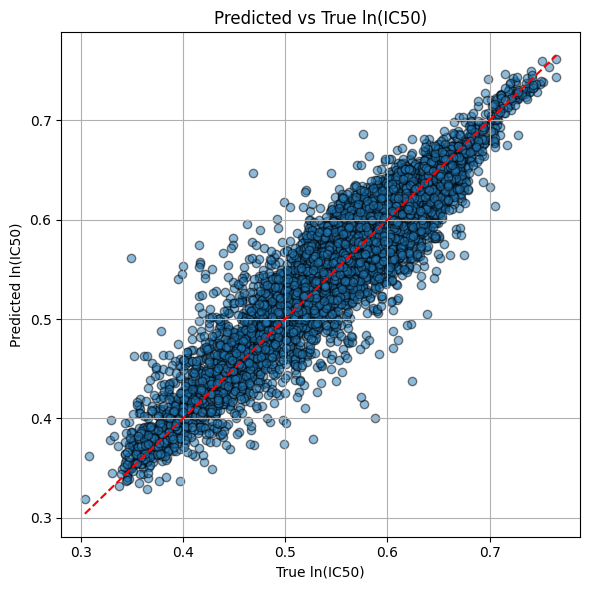

In [51]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True ln(IC50)")
plt.ylabel("Predicted ln(IC50)")
plt.title("Predicted vs True ln(IC50)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
def print_parameter_breakdown(model):
    total = 0
    print("\nTrainable Parameters by Module:\n")
    for name, param in model.named_parameters():
        if param.requires_grad:
            count = param.numel()
            print(f"{name:<50} {count:>10}")
            total += count
    print(f"\nTotal Trainable Parameters: {total:,}")

print_parameter_breakdown(model)



Trainable Parameters by Module:

drug_encoder.gats.0.att_src                               512
drug_encoder.gats.0.att_dst                               512
drug_encoder.gats.0.bias                                  128
drug_encoder.gats.0.lin.weight                          28160
drug_encoder.gats.1.att_src                               512
drug_encoder.gats.1.att_dst                               512
drug_encoder.gats.1.bias                                  128
drug_encoder.gats.1.lin.weight                          65536
drug_encoder.gats.2.att_src                               512
drug_encoder.gats.2.att_dst                               512
drug_encoder.gats.2.bias                                  128
drug_encoder.gats.2.lin.weight                          65536
drug_encoder.att_proj.weight                              128
drug_encoder.att_proj.bias                                  1
fp_encoder.conv.0.weight                                  256
fp_encoder.conv.0.bias              